# Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from keras import Model

tf.__version__

'2.12.0'

In [2]:
SLICE_DURATION = 0.1
SAMPLING_RATE = 16000
N_FFT = 512
HOP_LENGTH = N_FFT // 4
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000

N_KERNELS = 10
N_FILTERS = 1

In [3]:
def get_sliced_audio_samples(path, slice_duration, sampling_rate):
    y, sr = librosa.load(path, sr=sampling_rate, mono=True)
    samples_per_slice = int(slice_duration * sampling_rate)
    num_slices = int(len(y) / samples_per_slice)
    rounded_num_samples = num_slices * samples_per_slice
    rounded_y = y[:rounded_num_samples]
    return rounded_y.reshape(num_slices, samples_per_slice)

In [4]:
slices = get_sliced_audio_samples("males/0.wav", SLICE_DURATION, SAMPLING_RATE)

In [5]:
random_slice = slices[np.random.randint(len(slices))]

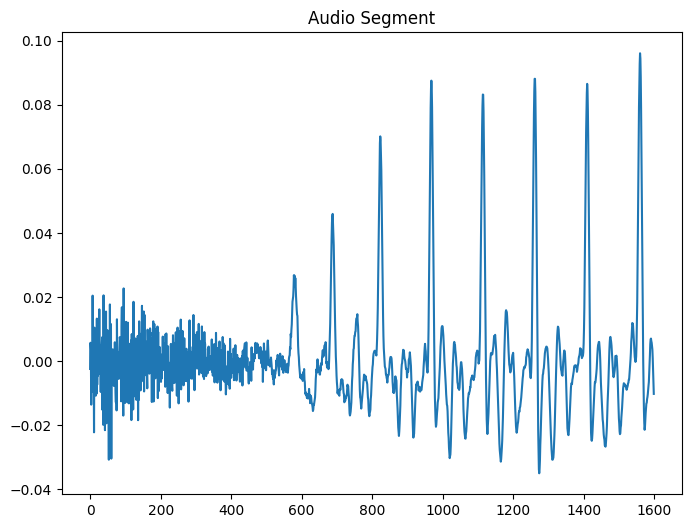

In [6]:
plt.figure(figsize=(8, 6))
plt.title('Audio Segment')
plt.plot(random_slice)

In [7]:
def get_stft(audio_slice, n_fft=N_FFT, hop_length=HOP_LENGTH):
    ft = librosa.stft(audio_slice, n_fft=n_fft, hop_length=hop_length)
    return abs(ft)

In [8]:
def plot_stft(ft, sampling_rate):
    db = librosa.amplitude_to_db(ft, ref=np.max)
    librosa.display.specshow(db, sr=sampling_rate, y_axis='log', x_axis='time')

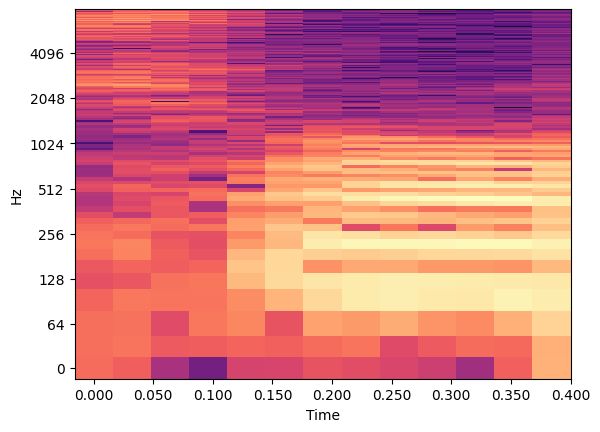

In [9]:
stft = get_stft(random_slice)
plot_stft(stft, SAMPLING_RATE)

In [10]:
def get_audio_slices_stft(path, slice_duration=SLICE_DURATION, sampling_rate=SAMPLING_RATE):
    audio_slices = get_sliced_audio_samples(path, slice_duration, sampling_rate)
    return np.array([get_stft(norm) for norm in audio_slices])

In [11]:
stft = get_audio_slices_stft("males/0.wav")
stft.shape, stft[0]

((55, 257, 13),
 array([[3.78686666e-01, 1.61183581e-01, 2.27720058e-03, ...,
         4.37632529e-03, 5.65502122e-02, 2.02282339e-01],
        [4.17160451e-01, 1.80539697e-01, 4.29245755e-02, ...,
         1.21518165e-01, 1.53942823e-01, 3.25904578e-01],
        [6.98493361e-01, 4.71687883e-01, 3.02227139e-01, ...,
         2.64252096e-01, 5.38194060e-01, 5.54516673e-01],
        ...,
        [1.53993035e-03, 1.14687392e-03, 9.84411687e-04, ...,
         7.39572162e-04, 7.31214648e-04, 2.13350030e-03],
        [1.79480389e-03, 8.69272626e-04, 1.28968130e-03, ...,
         8.10807978e-04, 1.67462602e-03, 2.71338481e-03],
        [1.83915044e-03, 1.22640282e-03, 1.44389004e-03, ...,
         9.09057795e-04, 3.52817064e-04, 2.70274119e-03]], dtype=float32))

In [12]:
STFT_SHAPE = stft.shape[-2:]
STFT_SHAPE

(257, 13)

# Create Train and Test Splits

In [13]:
male_voice_dir = "males"
female_voice_dir = "females"

In [14]:
def get_file_paths_from_dir(path):
    files = []

    for (_, _, filenames) in os.walk(path):
        files += [path + "/" + filename for filename in filenames]

    return files

In [15]:
file_paths = []
labels = []

male_voice_files = get_file_paths_from_dir(male_voice_dir)
file_paths += male_voice_files
labels += [1.0] * len(male_voice_files)

female_voice_files = get_file_paths_from_dir(female_voice_dir)
file_paths += female_voice_files
labels += [0.0] * len(female_voice_files)

In [16]:
train_files, val_files, train_labels, val_labels = train_test_split(
    file_paths,
    labels,
    test_size=0.1,
    shuffle=True,
    random_state=42
)

len(train_files), len(val_files), len(train_labels), len(val_labels)

(5393, 600, 5393, 600)

# Create Datasets

In [17]:
def audio_preprocess(file_path, label):
    slice_stfts = get_audio_slices_stft(file_path.numpy())
    labels = np.array([label.numpy()] * len(slice_stfts))
    expanded_slice_stfts = np.array([tf.expand_dims(slice_stft, -1) for slice_stft in slice_stfts])
    return expanded_slice_stfts, labels

In [18]:
def set_tensor_shapes(slice_data, label):
    slice_data.set_shape(STFT_SHAPE + (1,))
    label.set_shape(())
    return slice_data, label

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset = train_dataset.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

train_dataset = train_dataset.map(set_tensor_shapes)

train_dataset = train_dataset\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [20]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_dataset = val_dataset.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

val_dataset = val_dataset.map(set_tensor_shapes)

val_dataset = val_dataset\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [21]:
for audio_slice, label in train_dataset.take(2):
    print(audio_slice.shape)
    print(label.shape)

2023-06-11 00:43:17.445845: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(128, 257, 13, 1)
(128,)
(128, 257, 13, 1)
(128,)


2023-06-11 00:44:39.304571: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [22]:
for audio_slice, label in val_dataset.take(2):
    print(audio_slice.shape)
    print(label.shape)

(128, 257, 13, 1)
(128,)
(128, 257, 13, 1)
(128,)


2023-06-11 00:45:06.011935: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Train Models

## CNN Model


In [23]:
tf.random.set_seed(42)

inputs = Input(shape=STFT_SHAPE + (1,), name="input_layer")
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(inputs)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid", name="cnn_model")(x)
model_cnn = Model(inputs, outputs)

In [24]:
model_cnn.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [25]:
history_cnn = model_cnn.fit(train_dataset,
                        epochs=10,
                        validation_data=val_dataset)

Epoch 1/10
2922/2922 [==============================] - 286s 70ms/step - loss: 0.5910 - accuracy: 0.6913 - val_loss: 0.5546 - val_accuracy: 0.7257
Epoch 2/10
2922/2922 [==============================] - 36s 12ms/step - loss: 0.5298 - accuracy: 0.7381 - val_loss: 0.5262 - val_accuracy: 0.7386
Epoch 3/10
2922/2922 [==============================] - 35s 12ms/step - loss: 0.5079 - accuracy: 0.7507 - val_loss: 0.5177 - val_accuracy: 0.7445
Epoch 4/10
2922/2922 [==============================] - 33s 11ms/step - loss: 0.4935 - accuracy: 0.7597 - val_loss: 0.5090 - val_accuracy: 0.7508
Epoch 5/10
2922/2922 [==============================] - 32s 11ms/step - loss: 0.4843 - accuracy: 0.7662 - val_loss: 0.5035 - val_accuracy: 0.7550
Epoch 6/10
2922/2922 [==============================] - 32s 11ms/step - loss: 0.4775 - accuracy: 0.7712 - val_loss: 0.5055 - val_accuracy: 0.7548
Epoch 7/10
2922/2922 [==============================] - 33s 11ms/step - loss: 0.4728 - accuracy: 0.7742 - val_loss: 0.5006 

In [26]:
model_cnn.evaluate(val_dataset)

330/330 [==============================] - 1s 4ms/step - loss: 0.4934 - accuracy: 0.7656


[0.4934483468532562, 0.76556396484375]